# Pupillometry data processing
This notebook is intended to document the process to set up a pipeline for pupil diameter acquisition.

## Analize novel video using DeepLabCut model

In [2]:
import os
import deeplabcut



modelPath = 'Pupillometry2-Ryan-2022-04-07'
configPath = os.path.join(modelPath,'config.yaml')
videoPath = 'jounhong_TH_276_20220406_g0.mj2'
rawAnalysisResultPath = 'rawAnalysisResults/'
deeplabcut.analyze_videos(configPath, videoPath, destfolder=rawAnalysisResultPath)

PicklingError: Could not pickle object as excessively deep recursion required.

## Import data from deeplabcut output
Deeplabcut labels are stored in a multiindex pandas array with the file extension .h5, and contains the name of the network, body part name, (x, y) label position in pixels, and the likelihood for each frame per body part.

In [9]:
import pandas as pd
import numpy as np

labels = pd.read_hdf('jounhong_TH_276_20220406_g0-002DLC_resnet101_Pupillometry2Apr7shuffle1_1030000_filtered.h5')
labels

scorer    DLC_resnet101_Pupillometry2Apr7shuffle1_1030000              \
bodyparts                                      upperPupil               
coords                                                  x           y   
0                                              429.967651  167.714828   
1                                              430.423676  167.873352   
2                                              430.423676  167.873352   
3                                              430.404053  167.827911   
4                                              430.329102  167.806152   
...                                                   ...         ...   
114457                                         432.047607  135.977020   
114458                                         432.250885  135.733170   
114459                                         432.281525  135.464233   
114460                                         432.281525  134.581879   
114461                                         432.281525  134.520050   

scorer                                                                   \
bodyparts            upperRightPupil                         rightPupil   
coords    likelihood               x           y likelihood           x   
0                1.0      438.697144  167.760727        1.0  443.965912   
1                1.0      439.051575  167.996323        1.0  443.965912   
2                1.0      439.051575  168.017883        1.0  443.965912   
3                1.0      438.993652  167.996323        1.0  443.764648   
4                1.0      438.986633  167.760727        1.0  443.733154   
...              ...             ...         ...        ...         ...   
114457           1.0      445.219055  134.682343        1.0  455.741760   
114458           1.0      445.532867  134.489655        1.0  455.717285   
114459           1.0      445.821503  134.471680        1.0  455.640411   
114460           1.0      445.821503  134.228500        1.0  455.564362   
114461           1.0      445.821503  134.218750        1.0  455.564362   

scorer                                            ...             \
bodyparts                        lowerRightPupil  ... lowerPupil   
coords              y likelihood               x  ... likelihood   
0          172.737000        1.0      443.097534  ...        1.0   
1          172.804581        1.0      443.097534  ...        1.0   
2          173.100754        1.0      443.097534  ...        1.0   
3          172.986511        1.0      442.512909  ...        1.0   
4          172.804581        1.0      442.409088  ...        1.0   
...               ...        ...             ...  ...        ...   
114457     146.073624        1.0      451.524933  ...        1.0   
114458     145.994614        1.0      451.000885  ...        1.0   
114459     145.994614        1.0      450.849030  ...        1.0   
114460     145.982681        1.0      450.847107  ...        1.0   
114461     145.939423        1.0      450.814636  ...        1.0   

scorer                                                                   \
bodyparts lowerLeftPupil                          leftPupil               
coords                 x           y likelihood           x           y   
0             425.514160  186.291046        1.0  419.536530  181.589478   
1             425.514160  186.291046        1.0  419.582855  181.589478   
2             425.791046  186.291046        1.0  419.658783  181.589478   
3             425.675720  186.084290        1.0  419.582855  181.386749   
4             425.675720  186.073059        1.0  419.582855  181.199280   
...                  ...         ...        ...         ...         ...   
114457        426.783051  167.019440        1.0  414.191895  158.561676   
114458        426.326141  166.878204        1.0  414.179871  158.561676   
114459        425.865784  166.849716        1.0  414.072815  158.083725   
114460        425.660645  166.730453        1.0  414.029968  157.275330  

In [12]:
import cv2
cap = cv2.VideoCapture('jounhong_TH_276_20220406_g0.mj2')

frameNumber = 1000

# Get total number of frames
totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES,frameNumber)

ret, frame = cap.read()
name = str(frameNumber) + '.jpg'
cv2.imwrite(name, frame)

cap.release()
cv2.destroyAllWindows()

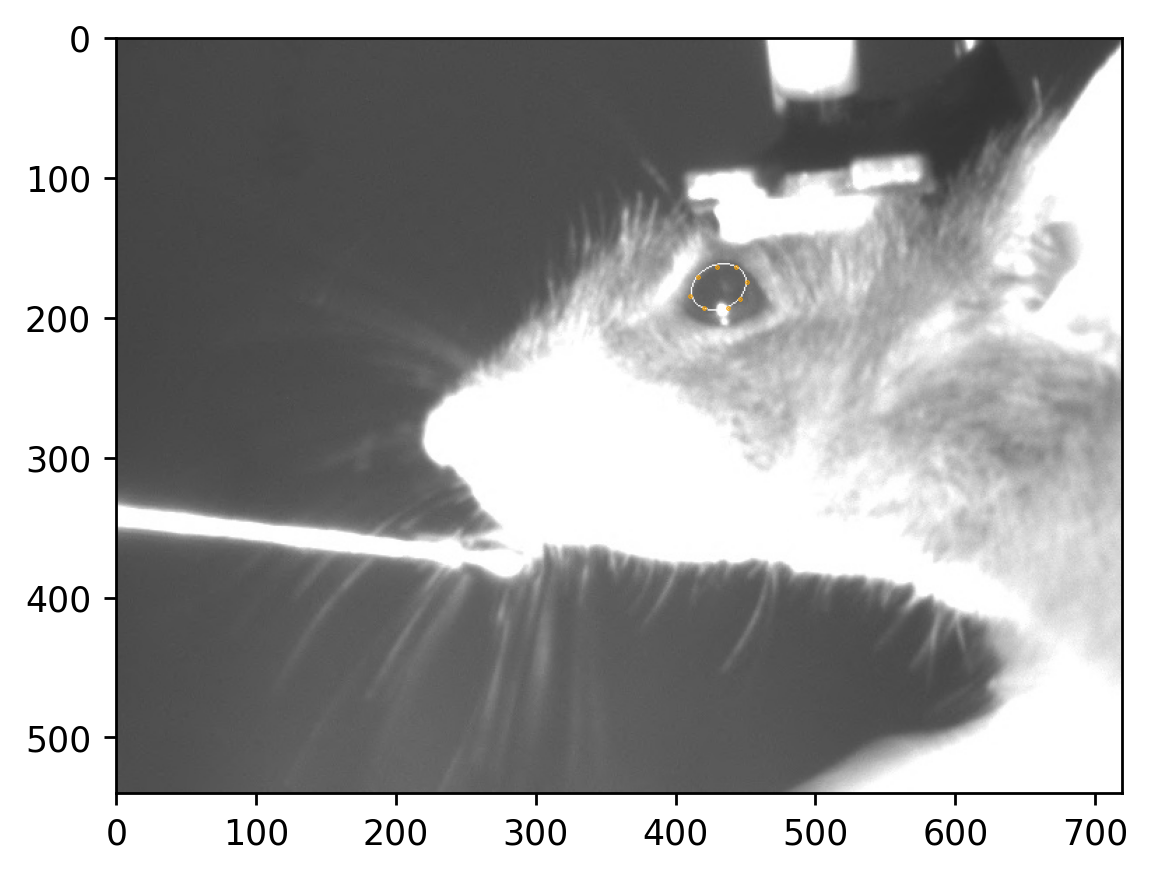

In [13]:
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.measure import EllipseModel
from skimage.draw import ellipse_perimeter

# Take a subset from the data
subset = labels.loc[frameNumber]
# Get the pupil markers (0 to 8) from the multiindex array obtained from deeplabcut
x = subset.xs('x', level='coords').to_numpy()[0:8]
y = subset.xs('y', level='coords').to_numpy()[0:8]
xy = np.column_stack((x,y))

# Estimate an ellipse based on the points generated around the pupil, this is enough to get an estimate of the pupil area in pixels
ellipse = EllipseModel()
ellipse.estimate(xy)

# Validate by ploting the points and the fitting ellipse on the image from the video
fig, ax = plt.subplots()
plt.rcParams['figure.dpi'] = 250
img = cv2.imread(str(frameNumber) + '.jpg')
ax.scatter(xy[:,0], xy[:,1], s=0.1, color='orange')
# Draw the ellipse on the original image
cy, cx = ellipse_perimeter(int(ellipse.params[1]), int(ellipse.params[0]), int(ellipse.params[3]), int(ellipse.params[2]), ellipse.params[4])
img[cy, cx] = 255
ax.imshow(img)

# Calculate the area of the elipse
ellipseArea = np.pi * ellipse.params[2] * ellipse.params[3]

As of now the result is not great, the points from the model have some error (they don't quite fit the pupil). I will work on improving the deeplabcut model and maybe do some changes in both illumination and the camera setup within the 30 Hz boundary. Another thing that could improve is the use of a larger mesh to allow more light into the camera and decrease the "blurriness".

## Get the pupil area based on fitted ellipse

In [14]:
df = pd.DataFrame(np.zeros(1), columns=['PupilDiameter'])
for i in range(labels.index.size):
    subset = labels.loc[i]
    x = subset.xs('x', level='coords').to_numpy()[0:8]
    y = subset.xs('y', level='coords').to_numpy()[0:8]
    xy = np.column_stack((x,y))
    # Fit the points to an ellipse and get the parameters (estimate X center coordinate, estimate Y center coordinate, a, b, theta)
    ellipse = EllipseModel()
    ellipse.estimate(xy)
    # Calculate the area of the ellipse from the parameters a and b
    ellipseArea = np.pi * ellipse.params[2] * ellipse.params[3]
    # Get the diameter of a circle from the area of the ellipse
    pupilDiameter = 2 * np.sqrt(ellipseArea/np.pi)
    df.loc[i] = pupilDiameter


## Get outliers
We are using a zcore > 2 to set the frame as outlier. Analysis of those images shows that they correspond to frame where either the mice have the eyes closed (blink or groom) or deeplabcut fails to track the pupil correctly.

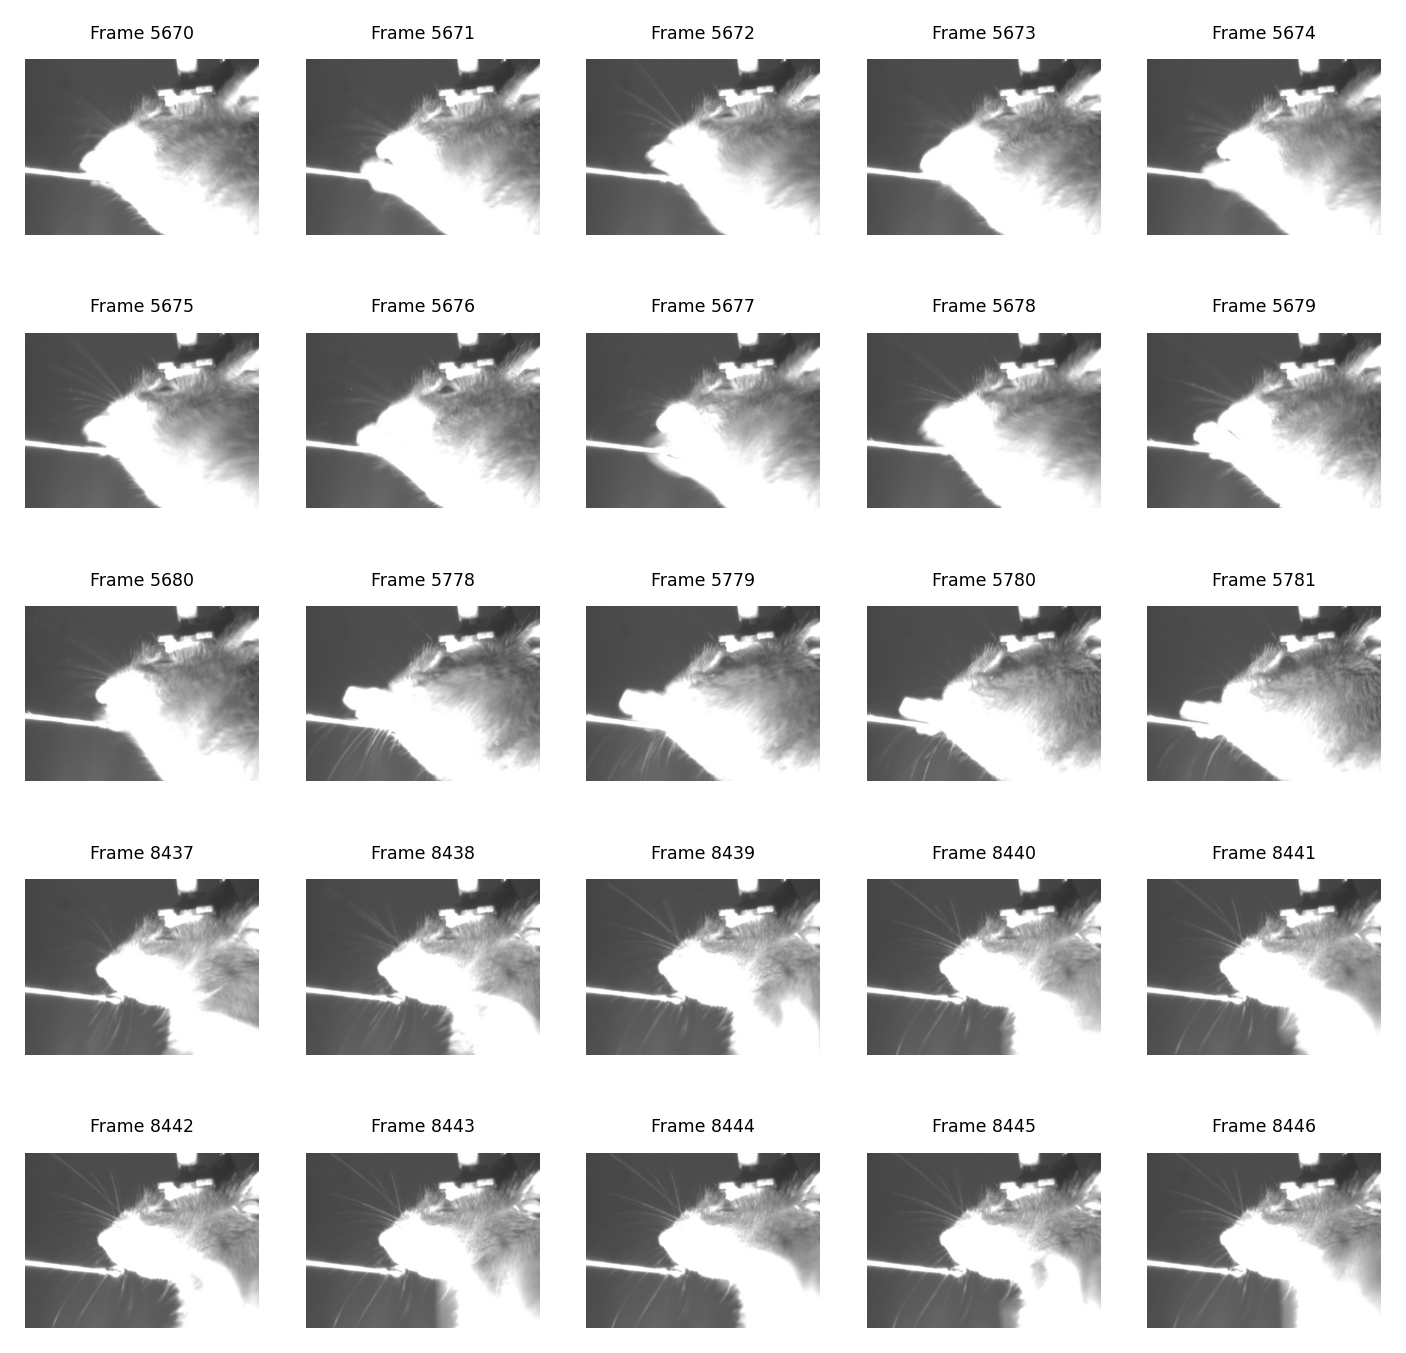

In [20]:
from scipy import stats
# Get a boolean array where true correspond to the frame with an outlier diameter
zscore = np.abs(stats.zscore(df))
outlierFlags = np.abs(stats.zscore(df)) > 2
outlierFlags = outlierFlags.rename(columns={outlierFlags.columns[0]: "OutlierFlag"})

# Get the list of outlier frames
from itertools import compress
outlierFrames = list(compress(range(len(outlierFlags)), outlierFlags['OutlierFlag']))

# Retrieve an outlier frames sample from the video for visual inspection
cap = cv2.VideoCapture('jounhong_TH_276_20220406_g0.mj2')
fig = plt.figure(figsize=(7, 7))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    # Get total number of frames
    totalFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES,outlierFrames[i])
    ret, frame = cap.read()

    fig.add_subplot(rows, columns, i)
    plt.title("Frame " + str(outlierFrames[i]), fontsize=5)
    plt.imshow(frame)
    plt.axis('off')
plt.show()
cap.release()
cv2.destroyAllWindows()


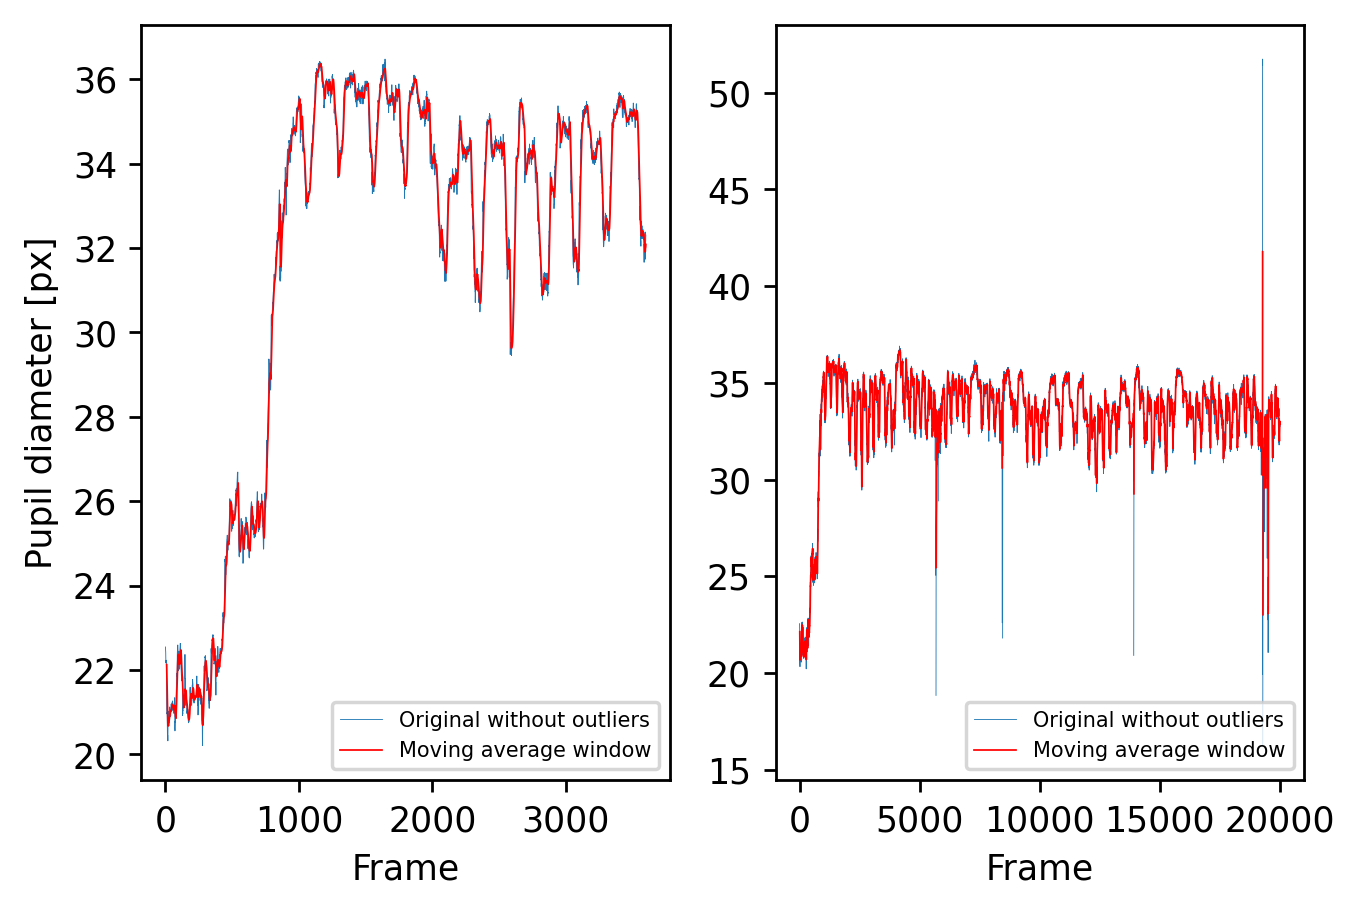

In [21]:
# Concatenate outlier flags array to remove outliers from pupil diameter array
temp = pd.concat([df, outlierFlags], axis=1)
temp.loc[temp['OutlierFlag']==True, 'PupilDiameter'] = None
pupilDiameter = temp['PupilDiameter']

# This might be better to leave open for the experimenter.
# Replace the outlier diameter data using a cubic spline interpolator
# pupilDiameter = temp['PupilDiameter'].interpolate(method='spline', order=3, s=0)

fig, (ax1, ax2) = plt.subplots(1,2)
# plt.rcParams['figure.dpi'] = 250

ax1.plot(pupilDiameter[0:3600], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax1.plot(pupilDiameter[0:3600].rolling(10).mean(), linewidth=0.5, color='red')
ax1.set_xlabel('Frame')
ax1.set_ylabel('Pupil diameter [px]')
ax1.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})

ax2.plot(pupilDiameter[0:20000], linewidth=0.25)
# Filter by using a moving average window of 10 samples
ax2.plot(pupilDiameter[0:20000].rolling(10).mean(), linewidth=0.5, color='red')
ax2.set_xlabel('Frame')
ax2.legend(['Original without outliers', 'Moving average window'], loc=4, prop={'size': 6})
#fig.savefig('test.eps', format='eps')

# Pupil diameter pipeline functions

In [1]:
# Pupil diameter pipeline functions

def analyzeVideo(videoPath, modelPath, destinationFolder):
    """
    Stores the analized video data from videoPath as h5 file in the destination folder using the DLC model in modelPath
    Arguments:
        videoPath: path of the video to analyze
        modelPath: path of the DLC model that will be used to analyze the video
        destinationFolder: path of the folder that will store the analyzed data results
    """
    # Analyze the video using the selected modelPath and videoPath
    import os
    import deeplabcut
    configPath = os.path.join(modelPath,'config.yaml')
    deeplabcut.analyze_videos(configPath, videoPath, destfolder=destinationFolder)

def getPupilDiameter(analyzedVideoDataPath):
    """
    Returns a pupil diameter numpy array from an analized video data stored in analyzedVideoDataPath
    Arguments:
        analyzedVideoDataPath: path of the video to analyze
    Returns:
        An array that contains the pupil diameter (index is the video frame) [numpy Array]
    """
    # TODO make the function
    from skimage.measure import EllipseModel
    from skimage.draw import ellipse_perimeter
    
    # Read the analyzed video data h5 file
    labels = pd.read_hdf(analyzedVideoDataPath)

    # Create a data frame of the same size ad the analyzed video data filled with zeros
    df = pd.DataFrame(np.zeros(1), columns=['PupilDiameter'])
    # For each frame, get the x and y coordinates of the points around the pupil, fit an ellipse and calculate the diameter of a circle with the same area as the ellipse
    for i in range(labels.index.size):
        subset = labels.loc[i]
        x = subset.xs('x', level='coords').to_numpy()[0:8]
        y = subset.xs('y', level='coords').to_numpy()[0:8]
        xy = np.column_stack((x,y))
        # Fit the points to an ellipse and get the parameters (estimate X center coordinate, estimate Y center coordinate, a, b, theta)
        ellipse = EllipseModel()
        ellipse.estimate(xy)
        # Calculate the area of the ellipse from the parameters a and b
        ellipseArea = np.pi * ellipse.params[2] * ellipse.params[3]
        # Get the diameter of a circle from the area of the ellipse
        pupilDiameter = 2 * np.sqrt(ellipseArea/np.pi)
        df.loc[i] = pupilDiameter

    # Get outliers (frames where either the mice have the eyes closed (blink or groom) or deeplabcut fails to track the pupil correctly)
    from scipy import stats
    # Calculate the zscore of the data frame
    zscore = np.abs(stats.zscore(df))
    # Set a treshold for a valid zscore value (determined empirically)
    outlierFlags = np.abs(stats.zscore(df)) > 2
    # Get a boolean array where true correspond to the frame with an outlier diameter
    outlierFlags = outlierFlags.rename(columns={outlierFlags.columns[0]: "OutlierFlag"})
    # Concatenate outlier flags array to remove outliers from pupil diameter array
    temp = pd.concat([df, outlierFlags], axis=1)
    temp.loc[temp['OutlierFlag']==True, 'PupilDiameter'] = None
    pupilDiameter = temp['PupilDiameter']
    
    return pupilDiameter.to_numpy()
    

In [1]:
from scripts.conf_file_finding import try_find_conf_file
try_find_conf_file()


Local configuration file found !!, no need to run the configuration (unless configuration has changed)


In [3]:
import datajoint as dj
import os
import pathlib
import pandas as pd

In [4]:
dj.conn()
acquisition_db = dj.create_virtual_module('acquisition', 'u19_acquisition')
pupillometry_db = dj.create_virtual_module('pupillometry', 'u19_pupillometry')

Connecting alvaros@datajoint00.pni.princeton.edu:3306


In [5]:
root_videopath = dj.config['custom']['dlc_root_data_dir']

modelPath = pathlib.Path(root_videopath, 'MODELS', 'Pupillometry2-Ryan-2022-04-07').as_posix()
configPath = pathlib.Path(modelPath,'config.yaml').as_posix()

proccesed_rootpath = dj.config['custom']['dlc_processed_data_dir']
proccesed_rootpath = pathlib.Path(proccesed_rootpath, 'pupillometry').as_posix()
configPath

'/mnt/cup/braininit/Data/Raw/video_acquisition/MODELS/Pupillometry2-Ryan-2022-04-07/config.yaml'

In [6]:
key = 'subject_fullname like "jounhong%"'
video_data_df = pd.DataFrame((pupillometry_db.PupillometrySession * acquisition_db.SessionVideo & key).fetch("KEY", 'remote_path_video_file', as_dict=True))

video_data_df['remote_path_video_file'] = 'pupillometry/' + video_data_df['remote_path_video_file']
video_data_df.loc[0,'remote_path_video_file']

video_data_df['processed_path'] = video_data_df['remote_path_video_file'].apply(lambda x : pathlib.Path(x).parent.as_posix())

video_data_df.loc[0, 'processed_path']

'pupillometry/jounhong/jounhong_TH_276/20220401_g0'

In [7]:
'''
for i in range(video_data_df.shape[0]-1,0,-1):
    this_video_path = pathlib.Path(root_videopath, video_data_df.loc[i, 'remote_path_video_file']).as_posix()
    this_results_path = pathlib.Path(proccesed_rootpath, video_data_df.loc[i, 'processed_path']).as_posix()

    pathlib.Path(this_results_path).mkdir(parents=True, exist_ok=True)

    print(this_video_path)
    print(this_results_path)
    deeplabcut.analyze_videos(configPath, this_video_path, destfolder=this_results_path)
'''

"\nfor i in range(video_data_df.shape[0]-1,0,-1):\n    this_video_path = pathlib.Path(root_videopath, video_data_df.loc[i, 'remote_path_video_file']).as_posix()\n    this_results_path = pathlib.Path(proccesed_rootpath, video_data_df.loc[i, 'processed_path']).as_posix()\n\n    pathlib.Path(this_results_path).mkdir(parents=True, exist_ok=True)\n\n    print(this_video_path)\n    print(this_results_path)\n    deeplabcut.analyze_videos(configPath, this_video_path, destfolder=this_results_path)\n"

In [8]:
'''
import u19_pipeline.utils.dlc_process as dlc


for i in range(video_data_df.shape[0]-1,0,-1):
    this_results_path = pathlib.Path(proccesed_rootpath, video_data_df.loc[i, 'processed_path']).as_posix()
    print(this_results_path)
    try:
        dlc.getPupilDiameter(destinationFolder=this_results_path)
    except BaseException as e:
        print(str(e))
'''

"\nimport u19_pipeline.utils.dlc_process as dlc\n\n\nfor i in range(video_data_df.shape[0]-1,0,-1):\n    this_results_path = pathlib.Path(proccesed_rootpath, video_data_df.loc[i, 'processed_path']).as_posix()\n    print(this_results_path)\n    try:\n        dlc.getPupilDiameter(destinationFolder=this_results_path)\n    except BaseException as e:\n        print(str(e))\n"

In [10]:
import u19_pipeline.automatic_job.clusters_paths_and_transfers as ft
import u19_pipeline.automatic_job.slurm_creator as sc
import subprocess
import u19_pipeline.automatic_job.params_config as config
import re
from u19_pipeline.utils.file_utils import write_file

repo_dir = '/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python'
script_path = pathlib.Path(repo_dir, 'u19_pipeline/utils/dlc_process.py').as_posix()

slurms_filepath = pathlib.Path(repo_dir, 'u19_pipeline/automatic_job/SlurmFiles').as_posix()
default_slurm_filename = 'slurm_real_spock.slurm'

for i in range(8, video_data_df.shape[0]):
    this_video_path = pathlib.Path(root_videopath, video_data_df.loc[i, 'remote_path_video_file']).as_posix()
    this_results_path = pathlib.Path(proccesed_rootpath, video_data_df.loc[i, 'processed_path']).as_posix()

    recording_process_id = str(i)

    #Get all associated directories given the selected processing cluster
    cluster_vars = ft.get_cluster_vars('spock')

    # Start with default values
    slurm_dict = cluster_vars['slurm_default'].copy()
    label_rec_process = 'rec'+recording_process_id
    print('label_rec_process', label_rec_process)
    slurm_dict['job-name'] = label_rec_process
    slurm_dict['output'] = str(pathlib.Path(cluster_vars['log_files_dir'],label_rec_process+ '.log'))
    slurm_text = sc.generate_slurm_dlc(slurm_dict)

    slurm_file_name = default_slurm_filename
    slurm_file_local_path = pathlib.Path(slurms_filepath,slurm_file_name).as_posix()

    write_file(slurm_file_local_path, slurm_text)

    #Get all associated variables given the selected processing cluster
    cluster_vars = ft.get_cluster_vars('spock')
        
    processed_data_directory = pathlib.Path(this_results_path).as_posix()
    repository_dir = repo_dir

    command = ['sbatch', 
    "--export=recording_process_id="+recording_process_id+
    ",raw_data_directory="+this_video_path+
    ",processed_data_directory="+processed_data_directory+
    ",repository_dir='"+repository_dir+
    "',process_script_path="+script_path+
    ",model_path="+modelPath
    , slurm_file_local_path
    ]

    print(command)
    p = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    #p = os.popen(command_new).read()
    p.wait()
    stdout, stderr = p.communicate()
    print('stdout', stdout.decode('UTF-8'))
    print('stderr', stderr.decode('UTF-8'))
    print('p.returncode', p.returncode)

    if p.returncode == config.system_process['SUCCESS']:
        batch_job_sentence = stdout.decode('UTF-8')
        print('batch_job_sentence', batch_job_sentence)
        id_slurm_job   = batch_job_sentence.replace("Submitted batch job ","")
        id_slurm_job   = re.sub(r"[\n\t\s]*", "", id_slurm_job)





label_rec_process rec8
['sbatch', "--export=recording_process_id=8,raw_data_directory=/mnt/cup/braininit/Data/Raw/video_acquisition/pupillometry/jounhong/jounhong_TH_276/20220411_g0/jounhong_TH_276_20220411_g0.mj2,processed_data_directory=/mnt/cup/braininit/Data/Processed/video_acquisition/pupillometry/pupillometry/jounhong/jounhong_TH_276/20220411_g0,repository_dir='/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python',process_script_path=/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python/u19_pipeline/utils/dlc_process.py,model_path=/mnt/cup/braininit/Data/Raw/video_acquisition/MODELS/Pupillometry2-Ryan-2022-04-07", '/usr/people/alvaros/BrainCogsProjects/Datajoint_projs/U19-pipeline_python/u19_pipeline/automatic_job/SlurmFiles/slurm_real_spock.slurm']
stdout Submitted batch job 26525497

stderr 
p.returncode 0
batch_job_sentence Submitted batch job 26525497

label_rec_process rec9
['sbatch', "--export=recording_process_id=9,raw_data_director